
# 한국은행(ECOS) 연습 문제1 — 인터넷뱅킹 관련 월별 시계열 분석

**안내 **

아래 조건을 **정확히 준수하여** Colab(또는 Jupyter) 환경에서 제공된 코드를 순서대로 실행하고, 결과 그래프와 수치(표)를 제출하세요.  
`api_key` 변수에 본인의 한국은행 ECOS API 키를 준비하세요.

---


### 요구 사항

통계표 코드(stat_code): 631Y001 (internet banking 관련 지표)

주기(frequency): 연간(A) — 연도(YYYY) 단위로 제공 (월별 데이터는 제공않은 항목)

세부항목(item_code1): H2200 (transfer amount — 자금이체(금액), 단위: 억원)

분석 기간: 2000 (2000년) 부터 2023 (2023년) 까지 (연도 형식 YYYY)

요청 URL 예시 포맷(자동 생성):

https://ecos.bok.or.kr/api/StatisticSearch/{api_key}/json/kr/1/9999/{stat_code}/A/{start}/{end}/{item_code1}




---

## 작업 순서 (상세)

### 1) 데이터 수집
- 위 고정 파라미터로 ECOS API를 호출하여 JSON 응답을 받으세요.
- 응답에서 `row`(또는 통계 데이터 리스트)를 추출하여 DataFrame으로 변환하세요.
- **예외 처리**: 응답에 `"RESULT"` 또는 `"해당하는 데이터가 없습니다."`가 포함되면 그 텍스트를 캡처하여 제출물에 첨부하세요.

### 2) 전처리 (CSV 저장까지)
1. **열 확인**  
 - 시간 컬럼(예: `TIME`)과 값 컬럼(예: `DATA_VALUE` 등)을 확인.
2. **시간 변환**  
 - `TIME` (YYYY) → `year` (int) 생성.  
 - `date` 컬럼 생성: `YYYY-01-01` 형식.  
 - `date`를 인덱스로 설정하고 오름차순 정렬.
3. **값 정리**  
 - 값 컬럼에서 콤마(,) 제거 후 숫자형으로 변환. 변환 불가 항목은 `NaN`.
4. **결측치 처리**  
 - `value`의 결측치는 **선형 보간(linear interpolation)** 으로 채움. (양끝 결측 포함 `limit_direction='both'`)  
 - 전처리 전/후 결측치 개수를 기록하여 보고서에 표기.
5. **보조 컬럼 생성**  
 - `value_interp` : 보간된 값(완성 시계열)  
 - `ma_3` : 3-year rolling mean (window=3, min_periods=1)  
 - `pct_yoy` : 연간 전년대비(%) = `(t - t-1) / t-1 * 100`
6. **기간별 평균 계산(수치 비교용)**  
 - `Recent 3-year mean` = 평균(`value_interp`, 2021–2023)  
 - `Previous 3-year mean` = 평균(`value_interp`, 2018–2020)  
 - 변화율(%) = `(recent - previous) / previous * 100`
7. **최신 관측치 비교**  
 - Latest year value (`value_interp` at max date)  
 - 1-year-ago value (latest year - 1)  
 - Latest YoY (%) 계산
8. **CSV 저장**  
 - 파일명: `ecos_631Y001_H2200_annual_cleaned.csv`  
 - 포함 컬럼: `TIME`, `year`, `date`, `value`, `value_interp`, `ma_3`, `pct_yoy` (이외 컬럼 포함 가능)

### 3) 시각화
1. **Time series plot** (`timeseries_internet_transfer_annual.png`)  
 - 그리기: `value_interp` (점 또는 선) + `ma_3` (선)를 겹쳐서 표시.  
 - Labels (영어): Title = `"Internet Banking — Transfer Amount (Annual)"`, x = `"Year"`, y = `"Amount (100 million KRW)"`.  
 - Legend 포함: e.g., `"Original (interpolated)"`, `"3-year moving average"`.  
 - 파일은 PNG 형식, 가로형 권장(최소 1200×600).
2. **Annual average bar chart**
 - 연도별 총금액(annual amount)을 막대그래프로 표시.  
 - Labels (영어): Title = `"Annual Amount by Year"`, x = `"Year"`, y = `"Total Amount (100 million KRW)"`.  

3. **월별 히트맵**  
 - 이 stat_code는 월별 데이터를 제공하지 않으므로 **월별 히트맵은 작성하지 않아도 됩니다.**

---

### 4) 제출 파일 목록
1. 전처리가 끝난 DataFrame을 ecos_631Y001_H2200_annual_cleaned.csv 로 저장

2. 작성한 파이썬 코드 문제1.ipynb

위 2개의 파일을 제출합니다.


### 결과 참고 이미지


<img src="https://imgur.com/vgHL5fe.png" width="80%">
<img src="https://imgur.com/WVVsePP.png" width="80%">
<img src="https://imgur.com/pHEhDUe.png" width="80%">








In [78]:
import requests
import json
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (12,5)
sns.set_style('whitegrid')

In [79]:
# ---------- SET YOUR API KEY HERE ----------
api_key = "Q5M1FTDZTGXSQ7D55I3J"
# -------------------------------------------

In [80]:
base = "https://ecos.bok.or.kr/api/StatisticSearch"

In [81]:
# Fixed parameters (exam conditions)
stat_code    = "631Y001"   # internet banking
freq         = "A"         # annual (fixed)
start_period = "2000"      # YYYY
end_period   = "2023"      # YYYY
item_code1   = "H2200"     # transfer amount (unit: 100 million KRW)

In [82]:
url = f"{base}/{api_key}/json/kr/1/9999/{stat_code}/{freq}/{start_period}/{end_period}/{item_code1}"

resp = requests.get(url, timeout=30)

In [83]:
resp

<Response [200]>

In [85]:
data = resp.json()
data

{'StatisticSearch': {'list_total_count': 24,
  'row': [{'STAT_CODE': '631Y001',
    'STAT_NAME': '7.6.1.1. 인터넷뱅킹',
    'ITEM_CODE1': 'H2200',
    'ITEM_NAME1': '자금이체 (금액)',
    'ITEM_CODE2': None,
    'ITEM_NAME2': None,
    'ITEM_CODE3': None,
    'ITEM_NAME3': None,
    'ITEM_CODE4': None,
    'ITEM_NAME4': None,
    'UNIT_NAME': '억원',
    'WGT': None,
    'TIME': '2000',
    'DATA_VALUE': '4241076'},
   {'STAT_CODE': '631Y001',
    'STAT_NAME': '7.6.1.1. 인터넷뱅킹',
    'ITEM_CODE1': 'H2200',
    'ITEM_NAME1': '자금이체 (금액)',
    'ITEM_CODE2': None,
    'ITEM_NAME2': None,
    'ITEM_CODE3': None,
    'ITEM_NAME3': None,
    'ITEM_CODE4': None,
    'ITEM_NAME4': None,
    'UNIT_NAME': '억원',
    'WGT': None,
    'TIME': '2001',
    'DATA_VALUE': '13642194'},
   {'STAT_CODE': '631Y001',
    'STAT_NAME': '7.6.1.1. 인터넷뱅킹',
    'ITEM_CODE1': 'H2200',
    'ITEM_NAME1': '자금이체 (금액)',
    'ITEM_CODE2': None,
    'ITEM_NAME2': None,
    'ITEM_CODE3': None,
    'ITEM_NAME3': None,
    'ITEM_CODE4': No

In [86]:
rows = data['StatisticSearch'].get('row', [])
rows

[{'STAT_CODE': '631Y001',
  'STAT_NAME': '7.6.1.1. 인터넷뱅킹',
  'ITEM_CODE1': 'H2200',
  'ITEM_NAME1': '자금이체 (금액)',
  'ITEM_CODE2': None,
  'ITEM_NAME2': None,
  'ITEM_CODE3': None,
  'ITEM_NAME3': None,
  'ITEM_CODE4': None,
  'ITEM_NAME4': None,
  'UNIT_NAME': '억원',
  'WGT': None,
  'TIME': '2000',
  'DATA_VALUE': '4241076'},
 {'STAT_CODE': '631Y001',
  'STAT_NAME': '7.6.1.1. 인터넷뱅킹',
  'ITEM_CODE1': 'H2200',
  'ITEM_NAME1': '자금이체 (금액)',
  'ITEM_CODE2': None,
  'ITEM_NAME2': None,
  'ITEM_CODE3': None,
  'ITEM_NAME3': None,
  'ITEM_CODE4': None,
  'ITEM_NAME4': None,
  'UNIT_NAME': '억원',
  'WGT': None,
  'TIME': '2001',
  'DATA_VALUE': '13642194'},
 {'STAT_CODE': '631Y001',
  'STAT_NAME': '7.6.1.1. 인터넷뱅킹',
  'ITEM_CODE1': 'H2200',
  'ITEM_NAME1': '자금이체 (금액)',
  'ITEM_CODE2': None,
  'ITEM_NAME2': None,
  'ITEM_CODE3': None,
  'ITEM_NAME3': None,
  'ITEM_CODE4': None,
  'ITEM_NAME4': None,
  'UNIT_NAME': '억원',
  'WGT': None,
  'TIME': '2002',
  'DATA_VALUE': '22371998'},
 {'STAT_CODE': '6

In [87]:
rows = rows if isinstance(rows, list) else [rows]
rows

[{'STAT_CODE': '631Y001',
  'STAT_NAME': '7.6.1.1. 인터넷뱅킹',
  'ITEM_CODE1': 'H2200',
  'ITEM_NAME1': '자금이체 (금액)',
  'ITEM_CODE2': None,
  'ITEM_NAME2': None,
  'ITEM_CODE3': None,
  'ITEM_NAME3': None,
  'ITEM_CODE4': None,
  'ITEM_NAME4': None,
  'UNIT_NAME': '억원',
  'WGT': None,
  'TIME': '2000',
  'DATA_VALUE': '4241076'},
 {'STAT_CODE': '631Y001',
  'STAT_NAME': '7.6.1.1. 인터넷뱅킹',
  'ITEM_CODE1': 'H2200',
  'ITEM_NAME1': '자금이체 (금액)',
  'ITEM_CODE2': None,
  'ITEM_NAME2': None,
  'ITEM_CODE3': None,
  'ITEM_NAME3': None,
  'ITEM_CODE4': None,
  'ITEM_NAME4': None,
  'UNIT_NAME': '억원',
  'WGT': None,
  'TIME': '2001',
  'DATA_VALUE': '13642194'},
 {'STAT_CODE': '631Y001',
  'STAT_NAME': '7.6.1.1. 인터넷뱅킹',
  'ITEM_CODE1': 'H2200',
  'ITEM_NAME1': '자금이체 (금액)',
  'ITEM_CODE2': None,
  'ITEM_NAME2': None,
  'ITEM_CODE3': None,
  'ITEM_NAME3': None,
  'ITEM_CODE4': None,
  'ITEM_NAME4': None,
  'UNIT_NAME': '억원',
  'WGT': None,
  'TIME': '2002',
  'DATA_VALUE': '22371998'},
 {'STAT_CODE': '6

In [42]:
df = pd.DataFrame(rows)

In [88]:
df.head()

STAT_CODE       STAT_NAME ITEM_CODE1 ITEM_NAME1 ITEM_CODE2  \
date                                                                    
2000-01-01   631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None   
2001-01-01   631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None   
2002-01-01   631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None   
2003-01-01   631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None   
2004-01-01   631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None   

           ITEM_NAME2 ITEM_CODE3 ITEM_NAME3 ITEM_CODE4 ITEM_NAME4 UNIT_NAME  \
date                                                                          
2000-01-01       None       None       None       None       None        억원   
2001-01-01       None       None       None       None       None        억원   
2002-01-01       None       None       None       None       None        억원   
2003-01-01       None       None       None       None       None        억원   
2004-01-01       None       None       None       None       None        억원   

             WGT  TIME DATA_VALUE  year     value  value_interp          ma_3  \
date                                                                            
2000-01-01  None  2000    4241076  2000   4241076       4241076  4.241076e+06   
2001-01-01  None  2001   13642194  2001  13642194      13642194  8.941635e+06   
2002-01-01  None  2002   22371998  2002  22371998      22371998  1.341842e+07   
2003-01-01  None  2003   28435211  2003  28435211      28435211  2.148313e+07   
2004-01-01  None  2004   32907138  2004  32907138      32907138  2.790478e+07   

               pct_yoy  
date                    
2000-01-01         NaN  
2001-01-01  221.668228  
2002-01-01   63.991203  
2003-01-01   27.101795  
2004-01-01   15.726723

In [ ]:
df.head()

In [45]:
df.columns.tolist()

['STAT_CODE',
 'STAT_NAME',
 'ITEM_CODE1',
 'ITEM_NAME1',
 'ITEM_CODE2',
 'ITEM_NAME2',
 'ITEM_CODE3',
 'ITEM_NAME3',
 'ITEM_CODE4',
 'ITEM_NAME4',
 'UNIT_NAME',
 'WGT',
 'TIME',
 'DATA_VALUE']

In [89]:
df['TIME']

date
2000-01-01    2000
2001-01-01    2001
2002-01-01    2002
2003-01-01    2003
2004-01-01    2004
2005-01-01    2005
2006-01-01    2006
2007-01-01    2007
2008-01-01    2008
2009-01-01    2009
2010-01-01    2010
2011-01-01    2011
2012-01-01    2012
2013-01-01    2013
2014-01-01    2014
2015-01-01    2015
2016-01-01    2016
2017-01-01    2017
2018-01-01    2018
2019-01-01    2019
2020-01-01    2020
2021-01-01    2021
2022-01-01    2022
2023-01-01    2023
Name: TIME, dtype: object

In [90]:
df['TIME'] = df['TIME'].astype(str)
df['TIME']

date
2000-01-01    2000
2001-01-01    2001
2002-01-01    2002
2003-01-01    2003
2004-01-01    2004
2005-01-01    2005
2006-01-01    2006
2007-01-01    2007
2008-01-01    2008
2009-01-01    2009
2010-01-01    2010
2011-01-01    2011
2012-01-01    2012
2013-01-01    2013
2014-01-01    2014
2015-01-01    2015
2016-01-01    2016
2017-01-01    2017
2018-01-01    2018
2019-01-01    2019
2020-01-01    2020
2021-01-01    2021
2022-01-01    2022
2023-01-01    2023
Name: TIME, dtype: object

In [91]:
df['year'] = df['TIME'].str.slice(0,4).astype(int)

In [20]:
df

STAT_CODE       STAT_NAME ITEM_CODE1 ITEM_NAME1 ITEM_CODE2 ITEM_NAME2  \
0    631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None       None   
1    631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None       None   
2    631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None       None   
3    631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None       None   
4    631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None       None   
5    631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None       None   
6    631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None       None   
7    631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None       None   
8    631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None       None   
9    631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None       None   
10   631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None       None   
11   631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None       None   
12   631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None       None   
13   631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None       None   
14   631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None       None   
15   631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None       None   
16   631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None       None   
17   631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None       None   
18   631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None       None   
19   631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None       None   
20   631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None       None   
21   631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None       None   
22   631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None       None   
23   631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None       None   

   ITEM_CODE3 ITEM_NAME3 ITEM_CODE4 ITEM_NAME4 UNIT_NAME   WGT  TIME  \
0        None       None       None       None        억원  None  2000   
1        None       None       None       None        억원  None  2001   
2        None       None       None       None        억원  None  2002   
3        None       None       None       None        억원  None  2003   
4        None       None       None       None        억원  None  2004   
5        None       None       None       None        억원  None  2005   
6        None       None       None       None        억원  None  2006   
7        None       None       None       None        억원  None  2007   
8        None       None       None       None        억원  None  2008   
9        None       None       None       None        억원  None  2009   
10       None       None       None       None        억원  None  2010   
11       None       None       None       None        억원  None  2011   
12       None       None       None       None        억원  None  2012   
13       None       None       None       None        억원  None  2013   
14       None       None       None       None        억원  None  2014   
15       None       None       None       None        억원  None  2015   
16       None       None       None       None        억원  None  2016   
17       None       None       None       None        억원  None  2017   
18       None       None       None       None        억원  None  2018   
19       None       None       None       None        억원  None  2019   
20       None       None       None       None        억원  None  2020   
21       None       None       None       None        억원  None  2021   
22       None       None       None       None        억원  None  2022   
23       None       None       None       None        억원  None  2023   

   DATA_VALUE  year  
0     4241076  2000  
1    13642194  2001  
2    22371998  2002  
3    28435211  2003  
4    32907138  2004  
5    44854112  2005  
6    54359852  2006  
7    67782333  2007  
8    78140861  2008  
9    95220398  2009  
10  107860811  2010  
11  116407524  2011  
12  121599425  

In [92]:
df['year'].astype(str) + '-01-01'

date
2000-01-01    2000-01-01
2001-01-01    2001-01-01
2002-01-01    2002-01-01
2003-01-01    2003-01-01
2004-01-01    2004-01-01
2005-01-01    2005-01-01
2006-01-01    2006-01-01
2007-01-01    2007-01-01
2008-01-01    2008-01-01
2009-01-01    2009-01-01
2010-01-01    2010-01-01
2011-01-01    2011-01-01
2012-01-01    2012-01-01
2013-01-01    2013-01-01
2014-01-01    2014-01-01
2015-01-01    2015-01-01
2016-01-01    2016-01-01
2017-01-01    2017-01-01
2018-01-01    2018-01-01
2019-01-01    2019-01-01
2020-01-01    2020-01-01
2021-01-01    2021-01-01
2022-01-01    2022-01-01
2023-01-01    2023-01-01
Name: year, dtype: object

In [93]:
df['date'] = pd.to_datetime(df['year'].astype(str) + '-01-01')
df.head()


STAT_CODE       STAT_NAME ITEM_CODE1 ITEM_NAME1 ITEM_CODE2  \
date                                                                    
2000-01-01   631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None   
2001-01-01   631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None   
2002-01-01   631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None   
2003-01-01   631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None   
2004-01-01   631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None   

           ITEM_NAME2 ITEM_CODE3 ITEM_NAME3 ITEM_CODE4 ITEM_NAME4 UNIT_NAME  \
date                                                                          
2000-01-01       None       None       None       None       None        억원   
2001-01-01       None       None       None       None       None        억원   
2002-01-01       None       None       None       None       None        억원   
2003-01-01       None       None       None       None       None        억원   
2004-01-01       None       None       None       None       None        억원   

             WGT  TIME DATA_VALUE  year     value  value_interp          ma_3  \
date                                                                            
2000-01-01  None  2000    4241076  2000   4241076       4241076  4.241076e+06   
2001-01-01  None  2001   13642194  2001  13642194      13642194  8.941635e+06   
2002-01-01  None  2002   22371998  2002  22371998      22371998  1.341842e+07   
2003-01-01  None  2003   28435211  2003  28435211      28435211  2.148313e+07   
2004-01-01  None  2004   32907138  2004  32907138      32907138  2.790478e+07   

               pct_yoy       date  
date                               
2000-01-01         NaN 2000-01-01  
2001-01-01  221.668228 2001-01-01  
2002-01-01   63.991203 2002-01-01  
2003-01-01   27.101795 2003-01-01  
2004-01-01   15.726723 2004-01-01

In [94]:
df.columns.tolist()

['STAT_CODE',
 'STAT_NAME',
 'ITEM_CODE1',
 'ITEM_NAME1',
 'ITEM_CODE2',
 'ITEM_NAME2',
 'ITEM_CODE3',
 'ITEM_NAME3',
 'ITEM_CODE4',
 'ITEM_NAME4',
 'UNIT_NAME',
 'WGT',
 'TIME',
 'DATA_VALUE',
 'year',
 'value',
 'value_interp',
 'ma_3',
 'pct_yoy',
 'date']

In [22]:
# val_col = None
# for c in df.columns:
#     if 'DATA' in c.upper() and 'VALUE' in c.upper():
#         val_col = c
#         break
# if val_col is None:
#     # fallback: first numeric-looking column (exclude TIME)
#     for c in df.columns:
#         if c == 'TIME': continue
#         try:
#             pd.to_numeric(df[c].astype(str).str.replace(',', ''), errors='raise')
#             val_col = c
#             break
#         except:
#             continue
# if val_col is None:
#     raise RuntimeError("Could not find value column in response. Columns: " + str(df.columns.tolist()))

In [50]:
val_col='DATA_VALUE'

In [51]:
val_col

'DATA_VALUE'

In [53]:
df['value'] = pd.to_numeric(df[val_col].astype(str).str.replace(',', '').replace('', np.nan), errors='coerce')
df.head()

STAT_CODE       STAT_NAME ITEM_CODE1 ITEM_NAME1 ITEM_CODE2 ITEM_NAME2  \
0   631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None       None   
1   631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None       None   
2   631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None       None   
3   631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None       None   
4   631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None       None   

  ITEM_CODE3 ITEM_NAME3 ITEM_CODE4 ITEM_NAME4 UNIT_NAME   WGT  TIME  \
0       None       None       None       None        억원  None  2000   
1       None       None       None       None        억원  None  2001   
2       None       None       None       None        억원  None  2002   
3       None       None       None       None        억원  None  2003   
4       None       None       None       None        억원  None  2004   

  DATA_VALUE  year       date     value  
0    4241076  2000 2000-01-01   4241076  
1   13642194  2001 2001-01-01  13642194  
2   22371998  2002 2002-01-01  22371998  
3   28435211  2003 2003-01-01  28435211  
4   32907138  2004 2004-01-01  32907138

In [62]:
df.columns.tolist()

['STAT_CODE',
 'STAT_NAME',
 'ITEM_CODE1',
 'ITEM_NAME1',
 'ITEM_CODE2',
 'ITEM_NAME2',
 'ITEM_CODE3',
 'ITEM_NAME3',
 'ITEM_CODE4',
 'ITEM_NAME4',
 'UNIT_NAME',
 'WGT',
 'TIME',
 'DATA_VALUE',
 'year',
 'value',
 'value_interp',
 'ma_3',
 'pct_yoy']

In [95]:
# index and sorting
df = df.set_index('date').sort_index()

In [96]:
df.head()

STAT_CODE       STAT_NAME ITEM_CODE1 ITEM_NAME1 ITEM_CODE2  \
date                                                                    
2000-01-01   631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None   
2001-01-01   631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None   
2002-01-01   631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None   
2003-01-01   631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None   
2004-01-01   631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None   

           ITEM_NAME2 ITEM_CODE3 ITEM_NAME3 ITEM_CODE4 ITEM_NAME4 UNIT_NAME  \
date                                                                          
2000-01-01       None       None       None       None       None        억원   
2001-01-01       None       None       None       None       None        억원   
2002-01-01       None       None       None       None       None        억원   
2003-01-01       None       None       None       None       None        억원   
2004-01-01       None       None       None       None       None        억원   

             WGT  TIME DATA_VALUE  year     value  value_interp          ma_3  \
date                                                                            
2000-01-01  None  2000    4241076  2000   4241076       4241076  4.241076e+06   
2001-01-01  None  2001   13642194  2001  13642194      13642194  8.941635e+06   
2002-01-01  None  2002   22371998  2002  22371998      22371998  1.341842e+07   
2003-01-01  None  2003   28435211  2003  28435211      28435211  2.148313e+07   
2004-01-01  None  2004   32907138  2004  32907138      32907138  2.790478e+07   

               pct_yoy  
date                    
2000-01-01         NaN  
2001-01-01  221.668228  
2002-01-01   63.991203  
2003-01-01   27.101795  
2004-01-01   15.726723

In [57]:
df['value'].isna().sum()

np.int64(0)

In [97]:
df['value_interp'] = df['value'].interpolate(method='linear', limit_direction='both')

In [98]:
df['value_interp'].isna().sum()

np.int64(0)

In [99]:
df['ma_3'] = df['value_interp'].rolling(window=3, min_periods=1).mean()
df.head()

STAT_CODE       STAT_NAME ITEM_CODE1 ITEM_NAME1 ITEM_CODE2  \
date                                                                    
2000-01-01   631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None   
2001-01-01   631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None   
2002-01-01   631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None   
2003-01-01   631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None   
2004-01-01   631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None   

           ITEM_NAME2 ITEM_CODE3 ITEM_NAME3 ITEM_CODE4 ITEM_NAME4 UNIT_NAME  \
date                                                                          
2000-01-01       None       None       None       None       None        억원   
2001-01-01       None       None       None       None       None        억원   
2002-01-01       None       None       None       None       None        억원   
2003-01-01       None       None       None       None       None        억원   
2004-01-01       None       None       None       None       None        억원   

             WGT  TIME DATA_VALUE  year     value  value_interp          ma_3  \
date                                                                            
2000-01-01  None  2000    4241076  2000   4241076       4241076  4.241076e+06   
2001-01-01  None  2001   13642194  2001  13642194      13642194  8.941635e+06   
2002-01-01  None  2002   22371998  2002  22371998      22371998  1.341842e+07   
2003-01-01  None  2003   28435211  2003  28435211      28435211  2.148313e+07   
2004-01-01  None  2004   32907138  2004  32907138      32907138  2.790478e+07   

               pct_yoy  
date                    
2000-01-01         NaN  
2001-01-01  221.668228  
2002-01-01   63.991203  
2003-01-01   27.101795  
2004-01-01   15.726723

In [61]:
df['pct_yoy'] = df['value_interp'].pct_change(periods=1) * 100
df.head()

STAT_CODE       STAT_NAME ITEM_CODE1 ITEM_NAME1 ITEM_CODE2  \
date                                                                    
2000-01-01   631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None   
2001-01-01   631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None   
2002-01-01   631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None   
2003-01-01   631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None   
2004-01-01   631Y001  7.6.1.1. 인터넷뱅킹      H2200  자금이체 (금액)       None   

           ITEM_NAME2 ITEM_CODE3 ITEM_NAME3 ITEM_CODE4 ITEM_NAME4 UNIT_NAME  \
date                                                                          
2000-01-01       None       None       None       None       None        억원   
2001-01-01       None       None       None       None       None        억원   
2002-01-01       None       None       None       None       None        억원   
2003-01-01       None       None       None       None       None        억원   
2004-01-01       None       None       None       None       None        억원   

             WGT  TIME DATA_VALUE  year     value  value_interp          ma_3  \
date                                                                            
2000-01-01  None  2000    4241076  2000   4241076       4241076  4.241076e+06   
2001-01-01  None  2001   13642194  2001  13642194      13642194  8.941635e+06   
2002-01-01  None  2002   22371998  2002  22371998      22371998  1.341842e+07   
2003-01-01  None  2003   28435211  2003  28435211      28435211  2.148313e+07   
2004-01-01  None  2004   32907138  2004  32907138      32907138  2.790478e+07   

               pct_yoy  
date                    
2000-01-01         NaN  
2001-01-01  221.668228  
2002-01-01   63.991203  
2003-01-01   27.101795  
2004-01-01   15.726723

In [63]:
mean_recent_3 = df.loc['2021-01-01':'2023-12-31', 'value_interp'].mean()
mean_recent_3

np.float64(274647879.3333333)

In [64]:
mean_prev_3   = df.loc['2018-01-01':'2020-12-31', 'value_interp'].mean()
mean_prev_3

np.float64(188146000.33333334)

In [66]:
change_rate_3y = (mean_recent_3 - mean_prev_3) / mean_prev_3 * 100 if mean_prev_3 != 0 else np.nan
change_rate_3y

np.float64(45.975932970537166)

In [68]:
latest_date = df.index.max()
latest_date

Timestamp('2023-01-01 00:00:00')

In [69]:
latest_val = df.loc[latest_date, 'value_interp']
latest_val

np.int64(294802779)

In [70]:
one_year_ago = latest_date - pd.DateOffset(years=1)
one_year_ago

Timestamp('2022-01-01 00:00:00')

In [71]:
val_one_year_ago = df['value_interp'].get(one_year_ago, np.nan)
val_one_year_ago

np.int64(274372021)

In [72]:
val_one_year_ago = df['value_interp'].get(one_year_ago, np.nan)
val_one_year_ago

np.int64(274372021)

In [73]:
pct_yoy_latest = (latest_val - val_one_year_ago) / val_one_year_ago * 100 if pd.notna(val_one_year_ago) and val_one_year_ago != 0 else np.nan
pct_yoy_latest


np.float64(7.446370779912723)

In [74]:
print(f"\nLatest observation: {latest_date.year} = {latest_val:.3f} (unit: 100 million KRW)")
print(f"One year before: {one_year_ago.year} = {val_one_year_ago:.3f}")
print(f"YoY % (latest) = {pct_yoy_latest:.2f}%")
print(f"\nRecent 3-year mean (2021-2023): {mean_recent_3:.3f}")
print(f"Previous 3-year mean (2018-2020): {mean_prev_3:.3f}")
print(f"3-year change rate (%) = {change_rate_3y:.3f}")


Latest observation: 2023 = 294802779.000 (unit: 100 million KRW)
One year before: 2022 = 274372021.000
YoY % (latest) = 7.45%

Recent 3-year mean (2021-2023): 274647879.333
Previous 3-year mean (2018-2020): 188146000.333
3-year change rate (%) = 45.976


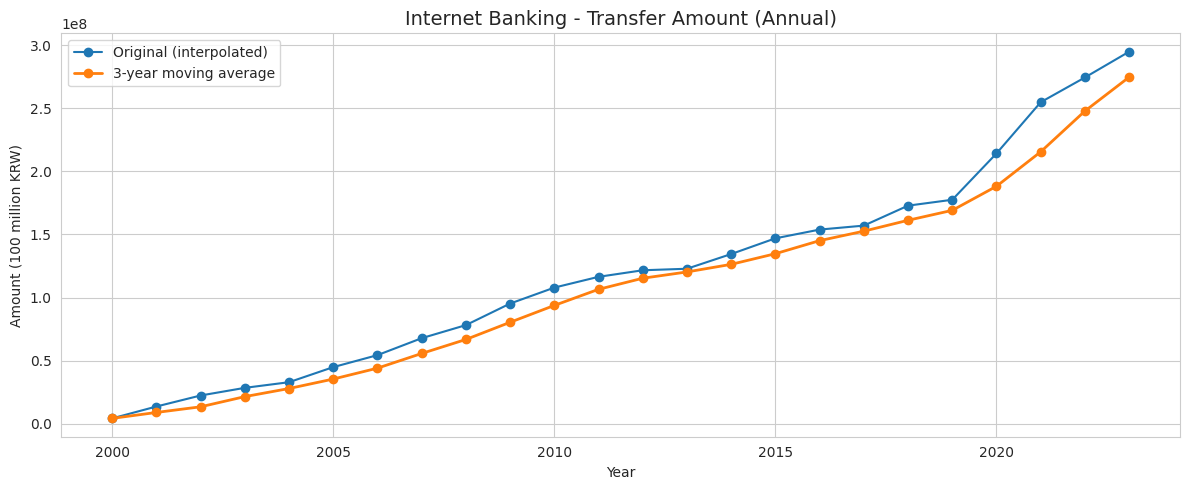

In [75]:
# Visualization (English labels)
# 1) Time series + 3-year moving average
plt.figure(figsize=(12,5))
plt.plot(df.index.year, df['value_interp'], marker='o', label='Original (interpolated)')
plt.plot(df.index.year, df['ma_3'], marker='o', label='3-year moving average', linewidth=2)
plt.title('Internet Banking - Transfer Amount (Annual)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Amount (100 million KRW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

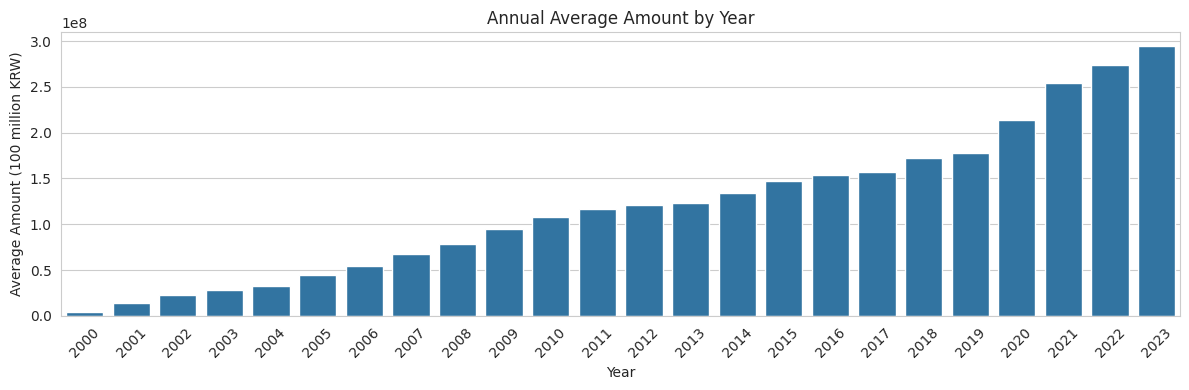

In [76]:
# 2) Annual mean bar plot (use 'YE' to avoid deprecation)
annual = df['value_interp'].resample('YE').mean()
annual.index = annual.index.year
plt.figure(figsize=(12,4))
sns.barplot(x=annual.index.astype(str), y=annual.values)
plt.xticks(rotation=45)
plt.title('Annual Average Amount by Year')
plt.xlabel('Year')
plt.ylabel('Average Amount (100 million KRW)')
plt.tight_layout()
plt.show()

In [77]:
# Save cleaned CSV
out_fname = f"ecos_{stat_code}_{item_code1}_annual_cleaned.csv"
df.to_csv(out_fname, encoding='utf-8-sig', index=True)
print("Saved:", out_fname)

Saved: ecos_631Y001_H2200_annual_cleaned.csv


In [101]:
df.dtypes

STAT_CODE        object
STAT_NAME        object
ITEM_CODE1       object
ITEM_NAME1       object
ITEM_CODE2       object
ITEM_NAME2       object
ITEM_CODE3       object
ITEM_NAME3       object
ITEM_CODE4       object
ITEM_NAME4       object
UNIT_NAME        object
WGT              object
TIME             object
DATA_VALUE       object
year              int64
value             int64
value_interp      int64
ma_3            float64
pct_yoy         float64
dtype: object